In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans


In [2]:
# Build U-Net model
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [3]:
import sys
sys.path.append('/home/anamika/ECE228/ECE228proj/unet-master')
from data import *

Using TensorFlow backend.


In [21]:
# train model with membrane data
imgs_train,imgs_mask_train = geneTrainNpy("unet-master/data/membrane/train/aug/","unet-master/data/membrane/train/aug/")
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1)
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True) #, callbacks=[model_checkpoint])


In [ ]:
# train model with ER data
#imgs_train,imgs_mask_train = geneTrainNpy("unet-master/data/membrane/train/aug/","unet-master/data/membrane/train/aug/")
imgs_train,imgs_mask_train = geneTrainNpy(image_path = "ERdata_Images/", mask_path = "ERdata_Masks/",image_prefix = "Image",mask_prefix = "Mask")
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1)
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True) #, callbacks=[model_checkpoint])


Train on 504 samples, validate on 126 samples
Epoch 1/10
110/504 [=====>........................] - ETA: 22:18 - loss: nan - accuracy: 0.1661

In [31]:
np.shape(imgs_mask_train)

(0,)

In [19]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

image_path = "ERdata_Images/"
mask_path = "ERdata_Masks/"
image_prefix = "Image"
mask_prefix = "Mask"
image_name_arr = glob.glob(os.path.join(image_path,"*%s*.png"%image_prefix))
image_as_gray = True
mask_as_gray = True
flag_multi_class = False
num_class = 2
image_arr = []
mask_arr = []
for index,item in enumerate(image_name_arr):
    img = io.imread(item,as_gray = image_as_gray)
    img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
    mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
    mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    image_arr.append(img)
    mask_arr.append(mask)
image_arr = np.array(image_arr)
mask_arr = np.array(mask_arr)

In [20]:
np.shape(image_arr)

(630, 512, 512, 1)

In [62]:
# test on ER data
from tif_parser import *
import matplotlib.pyplot as plt
imgtest = read_tiff("/home/anamika/ECE228/ECE228proj/006_colorized-RGB.tif",2)
#imgtest = read_tiff("/home/anamika/ECE228/ECE228proj/untreated_006_colorized.tif")
np.shape(imgtest)
plt.imshow(np.squeeze(imgtest[:,0,:256,:256]))
imgtest = np.squeeze(imgtest[:,0,:256,:256])
imgtest = imgtest.reshape(1,imgtest.shape[0],imgtest.shape[1],1)


IndexError: too many indices for array

In [49]:
np.shape(imgtest)

(1, 256, 256, 1)

1/1 [==============================] - 0s 288ms/sample


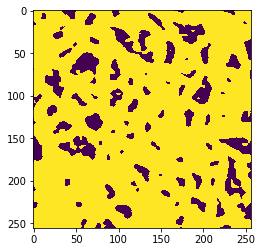

In [52]:
predict = model.predict(imgtest, verbose=1)
 
predict = (predict > 0.9999).astype(np.uint8)
 
plt.imshow(np.squeeze(predict[0]))
#plt.show()
 
#imshow(x_train[idx])
 
#plt.show()

In [57]:
# another method to read tiff file
from PIL import Image
im = Image.open("/home/anamika/ECE228/ECE228proj/untreated_006_colorized.tif")
#im.show()
import numpy
imarray = numpy.array(im)

In [77]:
import matplotlib.pyplot as plt
I = plt.imread("/home/anamika/ECE228/ECE228proj/untreated_006_colorized.tif")
I = I[256:,256:,2]
I = I.reshape(1,I.shape[0], I.shape[1],1)

In [78]:
np.shape(I)

(1, 256, 256, 1)

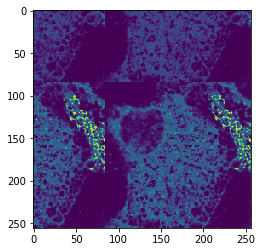

In [79]:
plt.imshow(np.squeeze(I))

1/1 [==============================] - 0s 406ms/sample


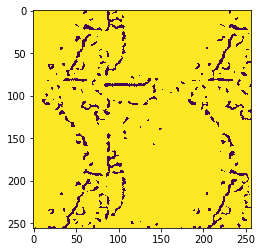

In [82]:
predict = model.predict(I, verbose=1)
 
predict = (predict > 0.2).astype(np.uint8)
 
plt.imshow(np.squeeze(predict[0]))

In [ ]:
# TO DO : Check with ER network img + mask from imageJ
# TO DO : Check if denoising makes the network segmentation better